In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd '/content/drive/MyDrive/Project'

/content/drive/.shortcut-targets-by-id/1rJqNaVhv0sfkYJG2oD_BHRhiVya6B7OJ/Project


In [5]:
#imports:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm, trange
import torch.nn.functional as F
from torchvision import transforms

In [6]:
# Constants:
CROP_X = 100
CROP_Y = 100
BATCH_SIZE = 32

#device:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
def crop_center(img, cropx, cropy):
    x, y  = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return img[startx:startx + cropx, starty:starty + cropy ]

def read_dataset(path):
    all_images = dict()
    for filename in tqdm(glob.iglob(path + '/*.png' , recursive=True) , desc = "Reading"):
        image = cv2.imread(filename , cv2.IMREAD_GRAYSCALE)
        image = crop_center(image , CROP_X , CROP_Y)
        image_name = filename.split('/')[2]
        all_images[image_name] = image
    return all_images


def matching (images , masks):
    dataset = []
    for image_name in images:
        image = images[image_name]
        image = image - image.min()
        image = image / image.max()
        image = torch.Tensor(image).unsqueeze(0)

        mask = masks[image_name]
        mask = mask - mask.min()
        mask = mask / mask.max()
        mask = torch.Tensor(mask).unsqueeze(0)
        dataset.append((image , mask))
    return dataset

In [8]:
train_images = read_dataset("dataset/train")
train_masks = read_dataset("dataset/train_label")
train_dataset = matching(train_images , train_masks)

test_images = read_dataset("dataset/test")
test_masks = read_dataset("dataset/test_label")
test_dataset = matching(test_images , test_masks)

In [9]:
%pip install -q "monai[tqdm, nibabel, gdown, ignite]"

     |████████████████████████████████| 358kB 17.6MB/s 
     |████████████████████████████████| 184kB 59.1MB/s 
     |████████████████████████████████| 81kB 12.2MB/s 


In [10]:
import monai
from monai.transforms import Compose ,ToTensorD,RandRotated, Rotate90d , RandFlipd , SpacingD , RandRotate90d , RandAffineD ,AddChannelD

In [11]:
from skimage import img_as_float64

In [12]:
KEYS = ("image", "mask")

xform = Compose([
    RandRotate90d(KEYS), 
    RandFlipd(KEYS),             
    ToTensorD(KEYS),
])

def augmentation(train_dataset):
    dataset = []
    for image , mask in train_dataset:
        image = img_as_float64(image)
        mask = img_as_float64(mask)

        data_dict = xform({"image": image, "mask": mask})
        image = data_dict["image"]
        mask = data_dict["mask"]
        dataset.append((image , mask))
    return dataset

In [13]:
aug_dataset = augmentation(train_dataset)

In [14]:
train_dataset = train_dataset + aug_dataset

In [15]:
train_loader = torch.utils.data.DataLoader(train_dataset , batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_dataset , batch_size=BATCH_SIZE)

# Model

In [169]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()

        self.zero_pad = nn.ZeroPad2d(padding=5)

        # Block 1
        self.conv1 = nn.Conv2d(1 , 64 , kernel_size=3, stride=1 , padding = 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1  = nn.ReLU()

        self.conv2 = nn.Conv2d(64 , 64 , kernel_size=3, stride=1 , padding = 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2  = nn.ReLU()

        self.conv3 = nn.Conv2d(64 , 64 , kernel_size=3, stride=1 , padding = 1)
        self.relu3  = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(64)

        self.pool1 = nn.MaxPool2d(kernel_size = 3 , stride = 2)
  


        # Block 2
        self.conv4 = nn.Conv2d(64 , 128 , kernel_size=3, stride=1 , padding = 1)
        self.bn4 = nn.BatchNorm2d(128)
        self.relu4  = nn.ReLU()

        self.conv5 = nn.Conv2d(128 , 128 , kernel_size=3, stride=1 , padding = 1)
        self.bn5 = nn.BatchNorm2d(128)
        self.relu5  = nn.ReLU()

        self.conv6 = nn.Conv2d(128 , 128 , kernel_size=3, stride=1 , padding = 1)
        self.bn6 = nn.BatchNorm2d(128)
        self.relu6  = nn.ReLU()

        self.conv7 = nn.Conv2d(128 , 128 , kernel_size=3, stride=1 , padding = 1)
        self.bn7 = nn.BatchNorm2d(128)
        self.relu7  = nn.ReLU()

        self.pool2 = nn.MaxPool2d(kernel_size = 3 , stride = 2)



        # Block 3
        self.conv8 = nn.Conv2d(128 , 256, kernel_size=3, stride=1, padding = 1)
        self.bn8 = nn.BatchNorm2d(256)
        self.relu8  = nn.ReLU()

        self.conv9 = nn.Conv2d(256 , 256, kernel_size=3, stride=1, padding = 1)
        self.bn9 = nn.BatchNorm2d(256)
        self.relu9  = nn.ReLU()

        self.conv10 = nn.Conv2d(256 , 256, kernel_size=3, stride=1, padding = 1)
        self.bn10 = nn.BatchNorm2d(256)
        self.relu10  = nn.ReLU()

        self.conv11 = nn.Conv2d(256 , 256, kernel_size=3, stride=1, padding = 1)
        self.bn11 = nn.BatchNorm2d(256)
        self.relu11  = nn.ReLU()

        self.pool3 = nn.MaxPool2d(kernel_size = 3 , stride = 2)

        self.dropout1 = nn.Dropout(0.5)


        # Block 4
        self.conv12 = nn.Conv2d(256 , 512, kernel_size=3, stride=1, padding = 1)
        self.bn12 = nn.BatchNorm2d(512)
        self.relu12  = nn.ReLU()

        self.conv13 = nn.Conv2d(512 , 512, kernel_size=3, stride=1, padding = 1)
        self.bn13 = nn.BatchNorm2d(512)
        self.relu13  = nn.ReLU()

        self.conv14 = nn.Conv2d(512 , 512, kernel_size=3, stride=1, padding = 1)
        self.bn14 = nn.BatchNorm2d(512)
        self.relu14  = nn.ReLU()

        self.conv15 = nn.Conv2d(512 , 512, kernel_size=3, stride=1, padding = 1)
        self.bn15 = nn.BatchNorm2d(512)
        self.relu15  = nn.ReLU()

        self.dropout2 = nn.Dropout(0.5)
        

        # Up Sampling
        self.unpsample1 = nn.ConvTranspose2d(512 , 256 ,kernel_size=3,stride=2)
        self.conv16 = nn.Conv2d(256 , 256, kernel_size=1, stride=1)
        self.bn16 = nn.BatchNorm2d(256)

        self.unpsample2 = nn.ConvTranspose2d(256 , 128 ,kernel_size=3,stride=2)
        self.conv17 = nn.Conv2d(128 , 128, kernel_size=2, stride=1)
        self.bn17 = nn.BatchNorm2d(128)

        self.unpsample3 = nn.ConvTranspose2d(128 , 64 ,kernel_size=3,stride=2)
        self.conv18 = nn.Conv2d(64 ,64, kernel_size=2, stride=1)
        self.bn18 = nn.BatchNorm2d(64)

        self.conv19 = nn.Conv2d(64 ,1, kernel_size=1, stride=1)

        self.sigmoid = nn.Sigmoid()
        self._initialize_weights()


    def forward(self, x):

        #print(x.shape)
        x = self.zero_pad(x)
        #print(x.shape)


        ############################################## Block 1
        x = self.relu1(self.bn1(self.conv1(x)))
        #print("1" , x.shape)    
        x = self.relu2(self.bn2(self.conv2(x)))
        #print("2" , x.shape)    
        x = self.relu3(self.bn3(self.conv3(x)))
        #print("3" , x.shape)    
        x = self.pool1(x)
        #print("pool 1 " , x.shape)   


        ############################################## Block 2
        x = self.relu4(self.bn4(self.conv4(x)))
        #print("4" , x.shape)    
        x = self.relu5(self.bn5(self.conv5(x)))
        #print("5" , x.shape)    
        x = self.relu6(self.bn6(self.conv6(x)))
        #print("6" , x.shape)  
        x = self.relu7(self.bn7(self.conv7(x)))
        #print("7" , x.shape)    
        x = self.pool2(x)
        #print("pool 2 " , x.shape)


        ############################################## Block 3
        x = self.relu8(self.bn8(self.conv8(x)))
        #print("8" , x.shape)    
        x = self.relu9(self.bn9(self.conv9(x)))
        #print("9" , x.shape)    
        x = self.relu10(self.bn10(self.conv10(x)))
        #print("10" , x.shape)    
        x = self.relu11(self.bn11(self.conv11(x)))
        #print("11" , x.shape)    
        x = self.pool3(x)
        #print("pool 3 " , x.shape)  

        x = self.dropout1(x)
        #print("drop out 1 " , x.shape)  


        ############################################## Block 4
        x = self.relu12(self.bn12(self.conv12(x)))
        #print("12" , x.shape)    

        x = self.relu13(self.bn13(self.conv13(x)))
        #print("13" , x.shape)    

        x = self.relu14(self.bn14(self.conv14(x)))
        #print("14" , x.shape)    
        x = self.relu15(self.bn15(self.conv15(x)))
        #print("15" , x.shape)    
        x = self.dropout2(x)
        #print("drop out 2 " , x.shape)  
        
        
        ############################################# Up Sampling 
        x = self.unpsample1(x)
        #print("up 1 " , x.shape)    
        x = self.bn16(self.conv16(x))
        #print("conv up 1 " , x.shape)    

        x = self.unpsample2(x)
        #print("up 2" , x.shape)    
        x = self.bn17(self.conv17(x))
        #print("conv up 2 " , x.shape)    

        x = self.unpsample3(x)
        #print("up 3" , x.shape)    

        x = self.bn18(self.conv18(x))
        #print("conv up 3 " , x.shape) 
         
        #############################################  Final
        x = self.conv19(x) 
        #print(x.shape)
        x = self.sigmoid(x)
        return x

    def _initialize_weights(self):
        for module in self.modules():
            if type(module) in { nn.Conv2d, nn.ConvTranspose2d}:
                torch.nn.init.xavier_normal_(module.weight)
                torch.nn.init.zeros_(module.bias)


In [39]:
def mvn(tensor):
    '''Performs per-channel spatial mean-variance normalization.'''
    epsilon = 1e-6
    mean = torch.mean(tensor, dim=(2,3), keepdims=True)
    std = torch.std(tensor, dim=(2,3), keepdims=True)
    mvn = (tensor - mean) / (std + epsilon)
    
    return mvn

In [57]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()

        self.zero_pad = nn.ZeroPad2d(padding=5)

        # Block 1
        self.conv1 = nn.Conv2d(1 , 64 , kernel_size=3, stride=1 , padding = 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1  = nn.ReLU()

        self.conv2 = nn.Conv2d(64 , 64 , kernel_size=3, stride=1 , padding = 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2  = nn.ReLU()

        self.conv3 = nn.Conv2d(64 , 64 , kernel_size=3, stride=1 , padding = 1)
        self.relu3  = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(64)

        self.pool1 = nn.MaxPool2d(kernel_size = 3 , stride = 2)
  


        # Block 2
        self.conv4 = nn.Conv2d(64 , 128 , kernel_size=3, stride=1 , padding = 1)
        self.bn4 = nn.BatchNorm2d(128)
        self.relu4  = nn.ReLU()

        self.conv5 = nn.Conv2d(128 , 128 , kernel_size=3, stride=1 , padding = 1)
        self.bn5 = nn.BatchNorm2d(128)
        self.relu5  = nn.ReLU()

        self.conv6 = nn.Conv2d(128 , 128 , kernel_size=3, stride=1 , padding = 1)
        self.bn6 = nn.BatchNorm2d(128)
        self.relu6  = nn.ReLU()

        self.conv7 = nn.Conv2d(128 , 128 , kernel_size=3, stride=1 , padding = 1)
        self.bn7 = nn.BatchNorm2d(128)
        self.relu7  = nn.ReLU()

        self.pool2 = nn.MaxPool2d(kernel_size = 3 , stride = 2)



        # Block 3
        self.conv8 = nn.Conv2d(128 , 256, kernel_size=3, stride=1, padding = 1)
        self.bn8 = nn.BatchNorm2d(256)
        self.relu8  = nn.ReLU()

        self.conv9 = nn.Conv2d(256 , 256, kernel_size=3, stride=1, padding = 1)
        self.bn9 = nn.BatchNorm2d(256)
        self.relu9  = nn.ReLU()

        self.conv10 = nn.Conv2d(256 , 256, kernel_size=3, stride=1, padding = 1)
        self.bn10 = nn.BatchNorm2d(256)
        self.relu10  = nn.ReLU()

        self.conv11 = nn.Conv2d(256 , 256, kernel_size=3, stride=1, padding = 1)
        self.bn11 = nn.BatchNorm2d(256)
        self.relu11  = nn.ReLU()

        self.pool3 = nn.MaxPool2d(kernel_size = 3 , stride = 2)

        self.dropout1 = nn.Dropout(0.5)


        # Block 4
        self.conv12 = nn.Conv2d(256 , 512, kernel_size=3, stride=1, padding = 1)
        self.bn12 = nn.BatchNorm2d(512)
        self.relu12  = nn.ReLU()

        self.conv13 = nn.Conv2d(512 , 512, kernel_size=3, stride=1, padding = 1)
        self.bn13 = nn.BatchNorm2d(512)
        self.relu13  = nn.ReLU()

        self.conv14 = nn.Conv2d(512 , 512, kernel_size=3, stride=1, padding = 1)
        self.bn14 = nn.BatchNorm2d(512)
        self.relu14  = nn.ReLU()

        self.conv15 = nn.Conv2d(512 , 512, kernel_size=3, stride=1, padding = 1)
        self.bn15 = nn.BatchNorm2d(512)
        self.relu15  = nn.ReLU()

        self.dropout2 = nn.Dropout(0.5)
        

        # Up Sampling
        self.unpsample1 = nn.ConvTranspose2d(512 , 256 ,kernel_size=3,stride=2)
        self.conv16 = nn.Conv2d(256 , 256, kernel_size=1, stride=1)
        self.bn16 = nn.BatchNorm2d(256)

        self.unpsample2 = nn.ConvTranspose2d(256 , 128 ,kernel_size=3,stride=2)
        self.conv17 = nn.Conv2d(128 , 128, kernel_size=2, stride=1)
        self.bn17 = nn.BatchNorm2d(128)

        self.unpsample3 = nn.ConvTranspose2d(128 , 64 ,kernel_size=3,stride=2)
        self.conv18 = nn.Conv2d(64 ,64, kernel_size=2, stride=1)
        self.bn18 = nn.BatchNorm2d(64)

        self.conv19 = nn.Conv2d(64 ,1, kernel_size=1, stride=1)

        self.sigmoid = nn.Sigmoid()
        self._initialize_weights()
        

    def forward(self, x):

        #print(x.shape)
        x = self.zero_pad(x)
        #print(x.shape)


        ############################################## Block 1
        x = self.relu1(mvn(self.conv1(x)))
        x = self.relu2(mvn(self.conv2(x)))
        x = self.relu3(mvn(self.conv3(x)))
        x = self.pool1(x)


        ############################################## Block 2
        x = self.relu4(mvn(self.conv4(x)))
        #print("4" , x.shape)    
        x = self.relu5(mvn(self.conv5(x)))
        #print("5" , x.shape)    
        x = self.relu6(mvn(self.conv6(x)))
        #print("6" , x.shape)  
        x = self.relu7(mvn(self.conv7(x)))
        #print("7" , x.shape)    
        x = self.pool2(x)
        #print("pool 2 " , x.shape)


        ############################################## Block 3
        x = self.relu8(mvn(self.conv8(x)))
        #print("8" , x.shape)    
        x = self.relu9(mvn(self.conv9(x)))
        #print("9" , x.shape)    
        x = self.relu10(mvn(self.conv10(x)))
        #print("10" , x.shape)    
        x = self.relu11(mvn(self.conv11(x)))
        #print("11" , x.shape)    
        x = self.pool3(x)
        #print("pool 3 " , x.shape)  

        x = self.dropout1(x)
        #print("drop out 1 " , x.shape)  


        ############################################## Block 4
        x = self.relu12(mvn(self.conv12(x)))
        #print("12" , x.shape)    

        x = self.relu13(mvn(self.conv13(x)))
        #print("13" , x.shape)    

        x = self.relu14(mvn(self.conv14(x)))
        #print("14" , x.shape)    
        x = self.relu15(mvn(self.conv15(x)))
        #print("15" , x.shape)    
        x = self.dropout2(x)
        #print("drop out 2 " , x.shape)  
        
        
        ############################################# Up Sampling 
        x = self.unpsample1(x)
        #print("up 1 " , x.shape)    
        x = mvn(self.conv16(x))
        #print("conv up 1 " , x.shape)    

        x = self.unpsample2(x)
        #print("up 2" , x.shape)    
        x = mvn(self.conv17(x))
        #print("conv up 2 " , x.shape)    

        x = self.unpsample3(x)
        #print("up 3" , x.shape)    

        x = mvn(self.conv18(x))
        #print("conv up 3 " , x.shape) 
         
        #############################################  Final
        x = self.conv19(x) 
        #print(x.shape)
        x = self.sigmoid(x)
        return x

    def _initialize_weights(self):
        for module in self.modules():
            if type(module) in { nn.Conv2d, nn.ConvTranspose2d}:
                torch.nn.init.xavier_normal_(module.weight)
                torch.nn.init.zeros_(module.bias)


In [170]:
def dice_metric(masks , pred_masks):
    dice = 0
    k = 0
    for i in range(len(masks)):
        k+=1
        im1 = masks[i].squeeze(0).cpu().detach()
        im2 = pred_masks[i].squeeze(0).cpu().detach()
        im2 = (im2>0.1).float()*1

        im1 = np.asarray(im1).astype(np.bool)
        im2 = np.asarray(im2).astype(np.bool)

        if im1.shape != im2.shape:
            raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

        # Compute Dice coefficient
        intersection = np.logical_and(im1, im2)
        dice += (2. * intersection.sum() / (im1.sum() + im2.sum()))

    return (dice /k)

In [175]:
def train():
    for epoch in range(1, N_EPOCH + 1):
        model.train()
        train_loss = 0
        batch_dice = 0
        k = 0
        for index , (images, masks) in enumerate(train_loader):
            k +=1
            images = images.float().to(device)
            masks = masks.float().to(device)
                
            optimizer.zero_grad()
            pred_masks = model(images)
            main_loss = F.binary_cross_entropy(pred_masks , masks)
            loss_L1 =  L1Loss(pred_masks.view(pred_masks.size(0),-1) , masks.view(masks.size(0),-1))
            loss = main_loss + 100 * loss_L1
            loss.backward()
            train_loss += loss.detach().cpu().numpy()
            optimizer.step()
            batch_dice += dice_metric(masks , pred_masks)
        print('Epoch: {}/{}\t Average loss: {:.4f} \t Average dice: {:.4f}'.format(epoch, N_EPOCH, train_loss /  k , batch_dice/ k ))
    
    return images , masks , pred_masks

In [176]:
def test():
    model.eval()
    test_loss = 0
    batch_dice = 0
    k = 0
    for index , (images, masks) in enumerate(test_loader):
        k +=1
        images = images.float().to(device)
        masks = masks.float().to(device)
        pred_masks = model(images)
        loss = F.binary_cross_entropy(pred_masks , masks)
        test_loss += loss.detach().cpu().numpy()
        batch_dice += dice_metric(masks , pred_masks)
    print('Average loss: {:.4f} \t Average dice: {:.4f}'.format( test_loss /  k , batch_dice/ k ))
    return images , masks , pred_masks

In [177]:
N_EPOCH = 50
LEARNING_RATE = 1e-2
MOMENTUM = 0.9

model = FCN().to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE , momentum=MOMENTUM)
criterion = nn.BCEWithLogitsLoss().to(device)
L1Loss = torch.nn.L1Loss().to(device)


In [178]:
tr_images , tr_masks , tr_pred_masks = train()
print("--------------------------------------------")
te_images , te_masks , te_pred_masks = test()

Epoch: 1/50	 Average loss: 10.8732 	 Average dice: 0.4625
Epoch: 2/50	 Average loss: 3.7369 	 Average dice: 0.7292
Epoch: 3/50	 Average loss: 2.7271 	 Average dice: 0.8138
Epoch: 4/50	 Average loss: 2.2235 	 Average dice: 0.8495
Epoch: 5/50	 Average loss: 1.8681 	 Average dice: 0.8740
Epoch: 6/50	 Average loss: 1.7497 	 Average dice: 0.8822
Epoch: 7/50	 Average loss: 1.7108 	 Average dice: 0.8839
Epoch: 8/50	 Average loss: 1.5682 	 Average dice: 0.8929
Epoch: 9/50	 Average loss: 1.4932 	 Average dice: 0.8988
Epoch: 10/50	 Average loss: 1.4274 	 Average dice: 0.9029
Epoch: 11/50	 Average loss: 1.4320 	 Average dice: 0.9020
Epoch: 12/50	 Average loss: 1.5169 	 Average dice: 0.8987
Epoch: 13/50	 Average loss: 1.3896 	 Average dice: 0.9077
Epoch: 14/50	 Average loss: 1.2317 	 Average dice: 0.9143
Epoch: 15/50	 Average loss: 1.1504 	 Average dice: 0.9195
Epoch: 16/50	 Average loss: 1.1436 	 Average dice: 0.9201
Epoch: 17/50	 Average loss: 1.1435 	 Average dice: 0.9189
Epoch: 18/50	 Average 

In [179]:
import random
def plot_results(images , masks , pred_masks):
    fig , (ax1 , ax2 , ax3) = plt.subplots(1,3,figsize=(10,8))
    a = random.choice(range(len(masks)))

    this_image = images[a].squeeze(0).cpu().detach()
    this_mask = masks[a].squeeze(0).cpu().detach()
    pred_mask = pred_masks[a].squeeze(0).cpu()
    print("dice for this image: " ,dice_metric(masks[a] , pred_masks[a]))
    pred_mask = (pred_mask>0.1).float()*1
    

    ax1.imshow(this_image , cmap = 'gray')
    ax2.imshow(this_mask , cmap = 'gray')
    ax3.imshow(pred_mask , cmap = 'gray')

    ax1.set_title("Image")
    ax2.set_title("GT mask")    
    ax3.set_title("Predicted mask")

dice for this image:  0.9689067201604814


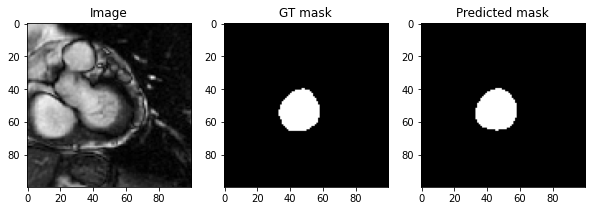

In [180]:
plot_results(tr_images , tr_masks , tr_pred_masks)

dice for this image:  0.8788368336025848


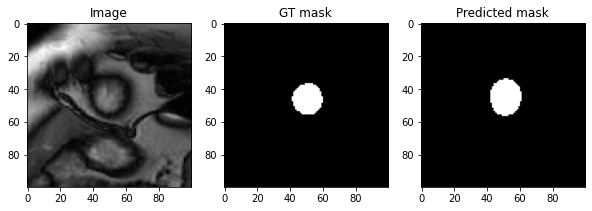

In [200]:
plot_results(te_images , te_masks , te_pred_masks)